In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# split
from sklearn.model_selection import StratifiedShuffleSplit

# from spam
from collections import Counter

# word embedding
from gensim.models import Word2Vec
import multiprocessing
from tqdm import tqdm

# keras
from keras.preprocessing import sequence
from keras.regularizers import l2
from keras.models import Model, Sequential
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Dense, GlobalMaxPooling1D, Activation, Dropout, GaussianNoise, LSTM, Bidirectional
from keras.layers import Embedding, Input, BatchNormalization, SpatialDropout1D, Conv1D, Concatenate
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import tensorflow as tf

from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score, classification_report

In [2]:
X_train = pd.read_pickle('X_train_new.pickle')
X_test = pd.read_pickle('X_test_new.pickle')

In [3]:
X_train.dropna(inplace= True)
X_test.dropna(inplace= True)

In [54]:
X_test.reset_index(inplace=True)

In [56]:
X_test

,index,tokenized_text,mental_state
0,0,i feel myself anymore i hate my school none pe...,1
1,1,monetary gifts kids it seems days kids always ...,0
2,2,cc room get enough love time day come play som...,0
3,3,you ever wonder extent you are actually contro...,0
4,4,my problems building i come clean it week hard...,1
...,...,...,...
366425,366557,i know me my girlfriend work,0
366426,366558,hey i new umm i think i writing some stuff tal...,0
366427,366559,it worth it probably i feel like everything i ...,2
366428,366560,i need help i feel my self slowly pulled depre...,1


In [4]:
max_features = 100

In [5]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train['tokenized_text']))
list_tokenized_train = tokenizer.texts_to_sequences(X_train['tokenized_text'])
list_tokenized_test = tokenizer.texts_to_sequences(X_test['tokenized_text'])

In [6]:
pad_train = pad_sequences(list_tokenized_train, maxlen=300, padding='post')
pad_test = pad_sequences(list_tokenized_test, maxlen=300, padding='post')

In [7]:
vocab_size = len(tokenizer.word_index)+1

In [18]:
y_target = pd.get_dummies(X_train['mental_state']).values
y_target_test = pd.get_dummies(X_test['mental_state']).values

https://medium.com/@sarin.samarth07/glove-word-embeddings-with-keras-python-code-52131b0c8b1d

In [9]:
embedding_vector = {}
f = open('glove.42B.300d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

1917495it [03:03, 10462.64it/s]


In [10]:
# create the embedding matrix
embedding_matrix = np.zeros((vocab_size,300))
# check if the word exist in tokenizer
for word,i in tqdm(t.word_index.items()):
    embedding_value = embedding_vector.get(word)
    # some words may not exist in Glove
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 257265/257265 [00:00<00:00, 332305.85it/s]


In [13]:
model = Sequential()
model.add(Embedding(vocab_size,300,weights = [embedding_matrix],input_length=300,trainable = False))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(3,activation = 'softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['accuracy'])


In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

history = model.fit(pad_train,y_target,epochs = 10,batch_size=256,validation_split=0.2, callbacks = [es])

Train on 1172541 samples, validate on 293136 samples
Epoch 1/10
1172541/1172541 [==============================] - 3731s 3ms/step - loss: 0.6920 - accuracy: 0.6853 - val_loss: 0.6850 - val_accuracy: 0.6887
Epoch 2/10
1172541/1172541 [==============================] - 3795s 3ms/step - loss: 0.6821 - accuracy: 0.6909 - val_loss: 0.6805 - val_accuracy: 0.6914
Epoch 3/10
1172541/1172541 [==============================] - 3952s 3ms/step - loss: 0.6763 - accuracy: 0.6939 - val_loss: 0.6762 - val_accuracy: 0.6931
Epoch 4/10
1172541/1172541 [==============================] - 3837s 3ms/step - loss: 0.6720 - accuracy: 0.6959 - val_loss: 0.6772 - val_accuracy: 0.6931
Epoch 5/10
1172541/1172541 [==============================] - 3929s 3ms/step - loss: 0.6687 - accuracy: 0.6977 - val_loss: 0.6733 - val_accuracy: 0.6949
Epoch 6/10
1172541/1172541 [==============================] - 3958s 3ms/step - loss: 0.6658 - accuracy: 0.6991 - val_loss: 0.6807 - val_accuracy: 0.6887
Epoch 7/10
1172541/1172541 [=

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1172541/1172541 [==============================] - 3973s 3ms/step - loss: 0.6597 - accuracy: 0.7025 - val_loss: 0.6745 - val_accuracy: 0.6950
Epoch 00009: early stopping


In [17]:
model.save("model_bilstm_10_epoch.h5")

In [29]:
def performance(y_true, y_hat):
    
    y_true = list(map(lambda x: np.argmax(x), y_true))
    y_hat = list(map(lambda x: np.argmax(x), y_hat))
    
    y_true_roc = pd.DataFrame(y_true, columns = ['mental_state'])
    y_hat_roc = pd.DataFrame(y_hat, columns = ['mental_state'])
    
    y_true_roc = pd.get_dummies(y_true_roc['mental_state']).values
    y_hat_roc = pd.get_dummies(y_hat_roc['mental_state']).values
    
    # result template
    print('-'*40+' Result Report '+'-'*40)
    
    # Accuracy
    print('Accuracy: ', accuracy_score(y_true,y_hat))
    
    # Confusion matrix
    print('\n')
    print('Confusion Matrix: \n', confusion_matrix(y_true,y_hat))
    print('\n')

    # Classification Report
    print('Classification Report: \n')
    print(classification_report(y_true, y_hat))
    print('\n')
    
    # Aggregated area under the ROC curve
    print('Area under ROC curve: ', roc_auc_score(y_true_roc, y_hat_roc, multi_class='ovo'))
    
    print('-'*95)

### Result

In [21]:
predictions = model.predict(pad_test)

In [32]:
performance(y_target_test, predictions)

---------------------------------------- Result Report ----------------------------------------
Accuracy:  0.6951150287913107


Confusion Matrix: 
 [[ 90957  12271   4734]
 [ 21207 121486  25432]
 [ 16534  31541  42268]]


Classification Report: 

              precision    recall  f1-score   support

           0       0.71      0.84      0.77    107962
           1       0.73      0.72      0.73    168125
           2       0.58      0.47      0.52     90343

    accuracy                           0.70    366430
   macro avg       0.68      0.68      0.67    366430
weighted avg       0.69      0.70      0.69    366430



Area under ROC curve:  0.7594554033221352
-----------------------------------------------------------------------------------------------


### Plot the history result to check for overfit

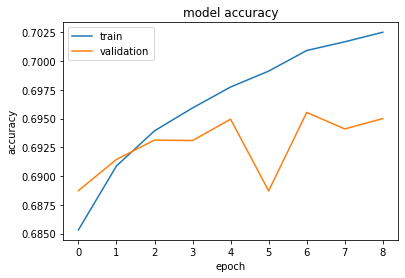

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

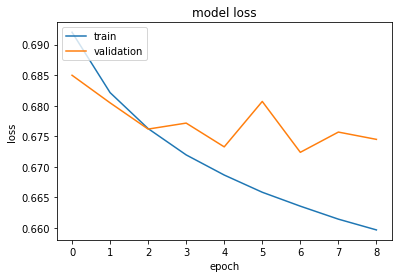

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [47]:
def check_mental_state(model, post, tokenizer):
    
    dic_state = {0:'Normal', 1:'Depressed', 2:'Suicidal'}
    
    SET_LIMIT_SENTENCE = 300
    
    print('Post: \n')
    print(post)
    print('\n')
    
    list_post = [post]
    list_post_tokenized = tokenizer.texts_to_sequences(list_post)
    post_pad = pad_sequences(list_post_tokenized, maxlen=SET_LIMIT_SENTENCE, padding='post')
    
    # classify mental state
    mental_state = model.predict(post_pad)
    
    print('Normal: ', str(round(mental_state[0][0], 2)*100)+'%')
    print('Depressed: ', str(round(mental_state[0][1], 2)*100)+'%')
    print('Suicidal: ', str(round(mental_state[0][2], 2)*100)+'%')
    
    classify_state = np.argmax(mental_state[0])
    #list(map(lambda x: np.argmax(x), mental_state))
    
    print('\n')
    print('Model Classify: ', dic_state[classify_state])

### Post Test

In [48]:
post = X_test[X_test['mental_state']==2]['tokenized_text'][19]
check_mental_state(model, post, tokenizer)

Post: 

i know i tried everything guys i gone different psychologists types anti depressants i made effort get bed every day walk my dog go gym read distant feeling increases exponentially day i never really loved life i loved people it lately spark disappeared i connect anyone fine i even connect my parents kills me inside i want stop mundane cycle my life become initially i told myself i stick it them i longer hold restrictions i always tried my best persevere keep looking forward i cried day today i realized threshold kept me taking action disappeared i want it feel selfish even thoughts somewhere i smiled loved i feel outcome inevitable please help


Normal:  0.9999999776482582%
Depressed:  70.99999785423279%
Suicidal:  28.00000011920929%


Model Classify:  Depressed


In [57]:
post = X_test[X_test['mental_state']==0]['tokenized_text'][2]
check_mental_state(model, post, tokenizer)

Post: 

cc room get enough love time day come play some music hang cc room great way find new music chatting lovely people we got people room we would love come party us follow link https hit headphones sidebar go room you need sign you account already it quick easy


Normal:  62.99999952316284%
Depressed:  31.00000023841858%
Suicidal:  5.999999865889549%


Model Classify:  Normal


In [60]:
post = X_test[X_test['mental_state']==1]['tokenized_text'][366423]
check_mental_state(model, post, tokenizer)

Post: 

i suicidal thoughts first time i suicidal thoughts i able speak my problems end my parents finally took me psychologist they always said i lazy lot sad things happened my grandfather passed away i terribly low i feeling hopeful barely suicidal thoughts still confidence months back my parents started arguing lot leading divorce my mom lied much got me stressed point i ca sleep night i also started going gym improve my i feel tired i think i give warning might trigger i tried commit suicide times never told my parents mostly tried hanging myself i always wanted die quickly last night i tried cut myself never thought i would i scared i might myself my psychologist vacation i feel guilty make my parents waste money me i think i deserve it i getting distant my friends i want hurt them i kill myself i trying keep my mind busy arguing making me stressed every day it seems like one end me amp amp


Normal:  5.000000074505806%
Depressed:  50.999999046325684%
Suicidal:  44.99999880790710

### ===========================AttentionLayer==========================

In [2]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [ ]:
inp = Input(shape=(pad_train.shape[1],), dtype='int64')
emb = Embedding(vocab_size,300,weights = [embedding_matrix],input_length=150,trainable = False)(inp)
RNN_CELL_SIZE = 75

#lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(emb)
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(emb)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

context_vector, attention_weights = Attention(10)(lstm, state_h)

dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
output = Dense(1, activation="softmax")(dropout)